#### Model: 

\begin{eqnarray}
X_t & = & A X_{t-1} + \nu_t,
\\
Y_t & = & C X_t + \omega_t,
\\
\nu_t & \sim & \text{N}(0, Q ) ~~ \text{with} ~ Q = \sigma_x^2 I,
\\
\omega_t & \sim & \text{N}(0, R) ~~ \text{with} ~ R = \sigma_y^2 I.
\end{eqnarray}

In [15]:
from __future__ import division
%matplotlib inline
from pykalman import KalmanFilter
import numpy as np, numpy.random as npr, matplotlib.pyplot as plt, copy, multiprocessing as mp
from scipy.stats import *
from pylab import plot, show, legend
from tqdm import trange
from functions_linear_gaussian_HMM import *

In [10]:
A = np.asarray([[0.9, -0.3], 
                [0.2, 1]])
C = np.asarray([[-1.1, 0.5],
                [-0.3, 0.8]])
# C = np.eye(2)
dim = np.shape(A)[0]
sigmax2 = 5e-1
sigmay2 = 5e-1
Q = sigmax2*np.eye(dim)
R = sigmay2*np.eye(dim)
mu0 = np.zeros(dim)
Sigma0 = np.eye(dim)

In [11]:
T = 1000
Y, X = generate_data_linear_gaussian(mu0, Sigma0, A, C, Q, R, T)

kf = KalmanFilter(initial_state_mean=mu0,
                  initial_state_covariance=Sigma0,
                  transition_matrices=A, 
                  observation_matrices=C, 
                  transition_covariance=Q, 
                  observation_covariance=R)
(filtered_state_means, filtered_state_covariances) = kf.filter(Y)

### Sanity checks:

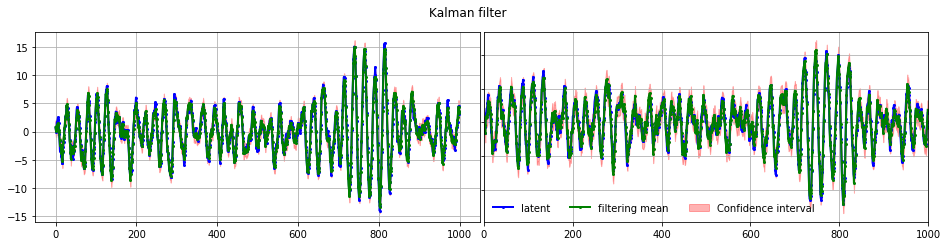

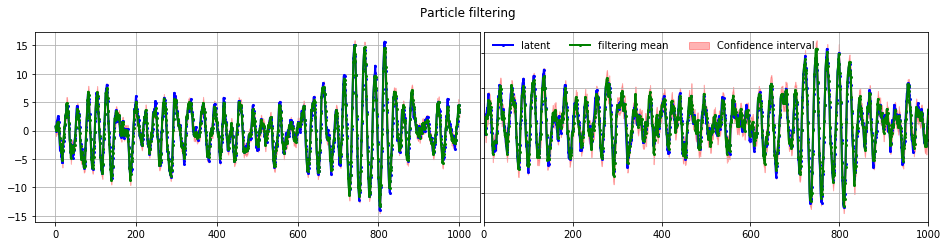

In [12]:
plt.rcParams['figure.figsize'] = (16, 3.5)
for i in range(2) :
    plt.subplot(1,2,i+1)
    plt.plot(X[:,i], "bo-", label="latent", markersize=2, linewidth=2)
    plt.plot(filtered_state_means[:,i], "go-", label="filtering mean", markersize=2, linewidth=2)
    plt.fill_between(np.arange(T), 
                     filtered_state_means[:,i] + 2*np.sqrt(filtered_state_covariances[:,i,i]), 
                     filtered_state_means[:,i] - 2*np.sqrt(filtered_state_covariances[:,i,i]), 
                     color='red', alpha=0.3, label="Confidence interval")
    if i == 1 : plt.yticks(alpha=0)
    plt.grid(True)
plt.legend(ncol=3, frameon=False)
plt.suptitle("Kalman filter")
plt.subplots_adjust(wspace=1e-2)
plt.xlim(0,T)
plt.show()

n_particles = 1000
logNC, particles = bootstrap_PF(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_particles)

for i in range(2) :
    plt.subplot(1,2,i+1)
    plt.plot(np.arange(1,T+1), X[:,i],  "bo-", label="latent", markersize=2, linewidth=2)
    plt.plot(np.arange(1,T+1), np.mean(particles[:,:,i],axis=1), "go-", label="filtering mean", markersize=2, linewidth=2)
    plt.fill_between(np.arange(1,T+1), 
                     np.percentile(particles[:,:,i],axis=1,q=5), 
                     np.percentile(particles[:,:,i],axis=1,q=95), 
                     color='red', alpha=0.3, label="Confidence interval")
    if i == 1 : plt.yticks(alpha=0)
    plt.grid(True)
plt.legend(ncol=3, frameon=False)
plt.suptitle("Particle filtering")
plt.subplots_adjust(wspace=1e-2)
plt.xlim(0,T);

### MCMC full data:

In [58]:
n_mcmc = 10_000
scale = np.asarray([0.3,0.3])

10.0 % run in 5.2 mins; acceptance rate = 0.26
20.0 % run in 10.4 mins; acceptance rate = 0.26
30.0 % run in 15.6 mins; acceptance rate = 0.26
40.0 % run in 20.8 mins; acceptance rate = 0.26
50.0 % run in 26.1 mins; acceptance rate = 0.27
60.0 % run in 31.3 mins; acceptance rate = 0.27
70.0 % run in 36.6 mins; acceptance rate = 0.26
80.0 % run in 41.9 mins; acceptance rate = 0.26
90.0 % run in 47.1 mins; acceptance rate = 0.26
100.0 % run in 52.3 mins; acceptance rate = 0.26
26.27 % acceptance rate


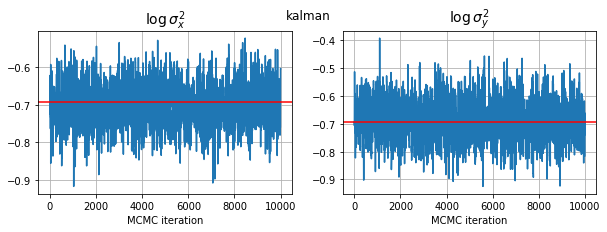

In [59]:
log_sigmay2_full, log_sigmax2_full, _, __ \
= adaptive_MH(Y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, scale=scale/np.sqrt(5), kappa=2, adapt=True)

plot(log_sigmay2_full, log_sigmax2_full, sigmax2, sigmay2, "kalman")

### Divide-and-conquer:

In [72]:
m = 5
K = int(T/m)
tstarts = K*np.arange(m).astype(int)
Ychunks = [Y[tstart:(K+tstart)] for tstart in tstarts]
def f(y) :
    return adaptive_MH(y, A, C, sigmax2, sigmay2, mu0, Sigma0, n_mcmc, 
                       scale=scale/np.sqrt(m), power=m, method="kalman", adapt=True, kappa=1.5)

In [73]:
pool = mp.Pool(m)
results = pool.map(f, [y for y in Ychunks])
pool.close()

10.0 % run in 1.0 mins; acceptance rate = 0.24
10.0 % run in 1.1 mins; acceptance rate = 0.25
10.0 % run in 1.1 mins; acceptance rate = 0.26
10.0 % run in 1.1 mins; acceptance rate = 0.28
10.0 % run in 1.1 mins; acceptance rate = 0.24
20.0 % run in 2.1 mins; acceptance rate = 0.24
20.0 % run in 2.1 mins; acceptance rate = 0.26
20.0 % run in 2.2 mins; acceptance rate = 0.26
20.0 % run in 2.2 mins; acceptance rate = 0.24
20.0 % run in 2.2 mins; acceptance rate = 0.26
30.0 % run in 3.2 mins; acceptance rate = 0.29
30.0 % run in 3.2 mins; acceptance rate = 0.28
30.0 % run in 3.3 mins; acceptance rate = 0.28
30.0 % run in 3.3 mins; acceptance rate = 0.3
30.0 % run in 3.3 mins; acceptance rate = 0.28
40.0 % run in 4.3 mins; acceptance rate = 0.31
40.0 % run in 4.3 mins; acceptance rate = 0.3
40.0 % run in 4.4 mins; acceptance rate = 0.32
40.0 % run in 4.4 mins; acceptance rate = 0.3
40.0 % run in 4.4 mins; acceptance rate = 0.33
50.0 % run in 5.4 mins; acceptance rate = 0.32
50.0 % run in 5.

In [76]:
xmax = np.max(np.asarray([np.max(results[i][0]) for i in range(m)]))
xmin = np.min(np.asarray([np.min(results[i][0]) for i in range(m)]))
ymax = np.max(np.asarray([np.max(results[i][1]) for i in range(m)]))
ymin = np.min(np.asarray([np.min(results[i][1]) for i in range(m)]))

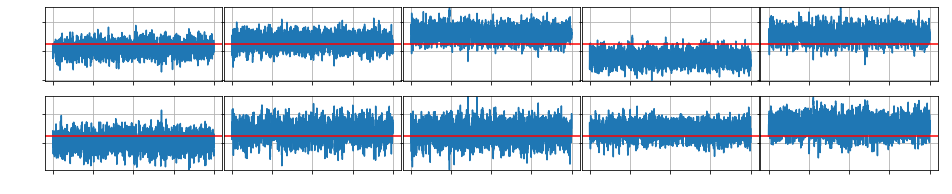

In [77]:
plt.rcParams['figure.figsize'] = (16, 3)
for i in range(m) :
    plt.subplot(2,m,i+1)
    plt.plot(results[i][0])
    plt.grid(True)
    plt.xticks(alpha=0)
    plt.yticks(alpha=0)
    plt.axhline(y=np.log(sigmax2), color="red")
    plt.ylim([xmin,xmax])
    
    plt.subplot(2,m,m+1+i)
    plt.plot(results[i][1])
    plt.grid(True)
    plt.xticks(alpha=0)
    plt.yticks(alpha=0)
    plt.axhline(y=np.log(sigmay2), color="red")
    plt.ylim([ymin,ymax])
plt.subplots_adjust(wspace=1e-2)

In [78]:
print(np.percentile(log_sigmay2_full, q=[2.5,97.5]))
print(np.percentile(log_sigmax2_full, q=[2.5,97.5]))

[-0.80948732 -0.58903825]
[-0.82466005 -0.54302723]


In [79]:
dc_ci = np.zeros((2,2))
for i in range(m) :
    dc_ci[0] += np.percentile(results[i][0], q=[2.5,97.5])/m
    dc_ci[1] += np.percentile(results[i][1], q=[2.5,97.5])/m

In [80]:
print(dc_ci[0])
print(dc_ci[1])

[-0.79840585 -0.57862862]
[-0.81130119 -0.52219462]
